# Exercises

**Implement the following CNN Architectures and check model parameters**

VGG Paper: https://arxiv.org/abs/1409.1556

Code samples: https://paperswithcode.com/paper/very-deep-convolutional-networks-for-large#code


1. VGG16

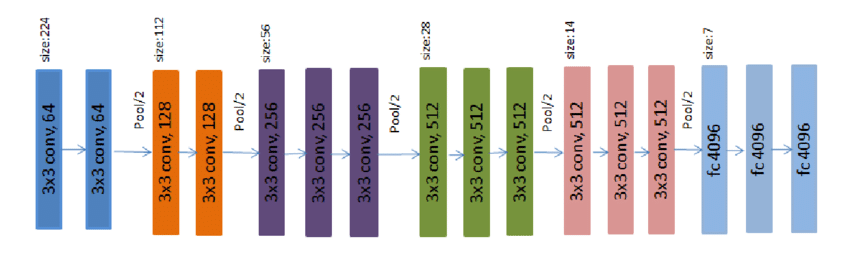

2. ResNet (https://arxiv.org/abs/1512.03385) and DenseNet (https://arxiv.org/abs/1608.06993) Implementation.
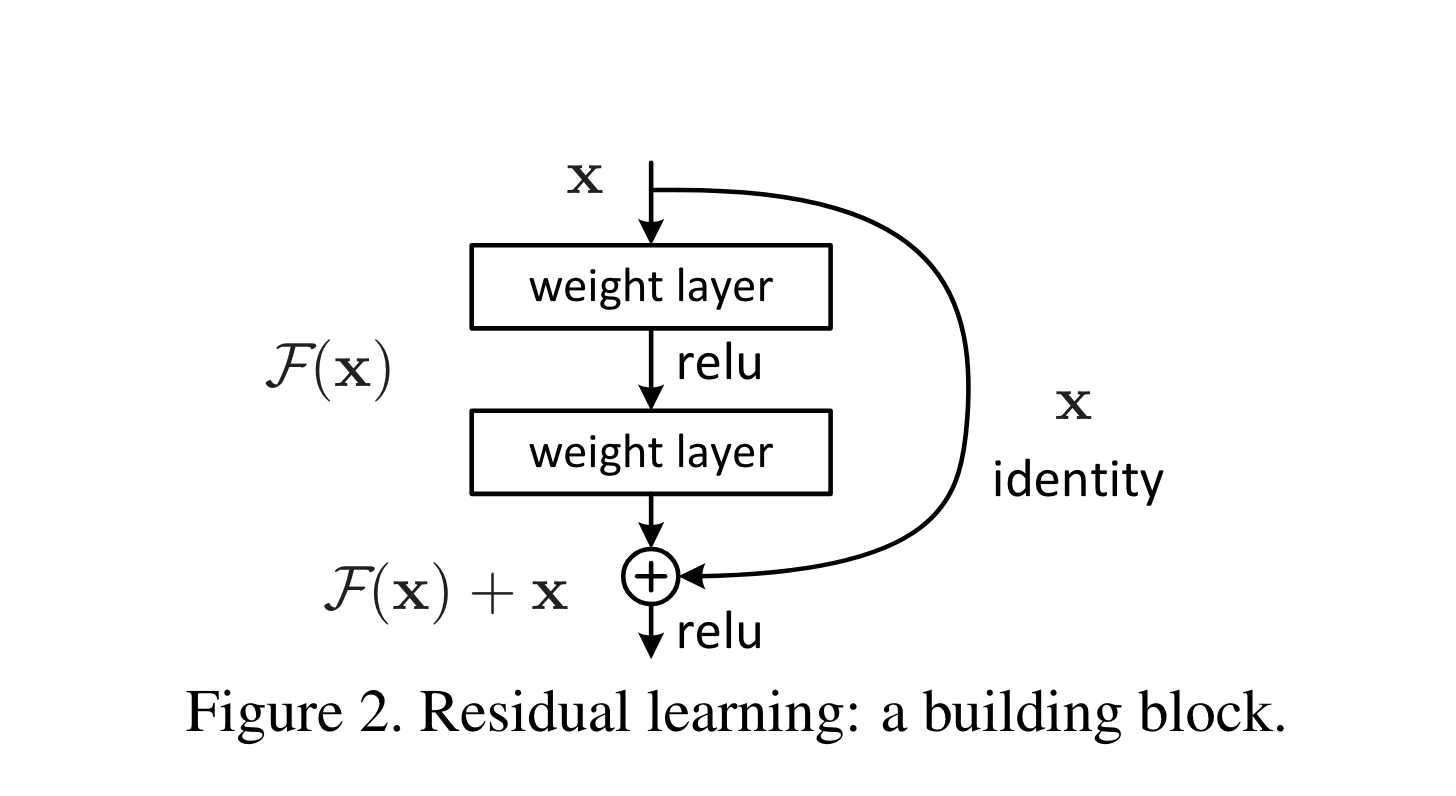


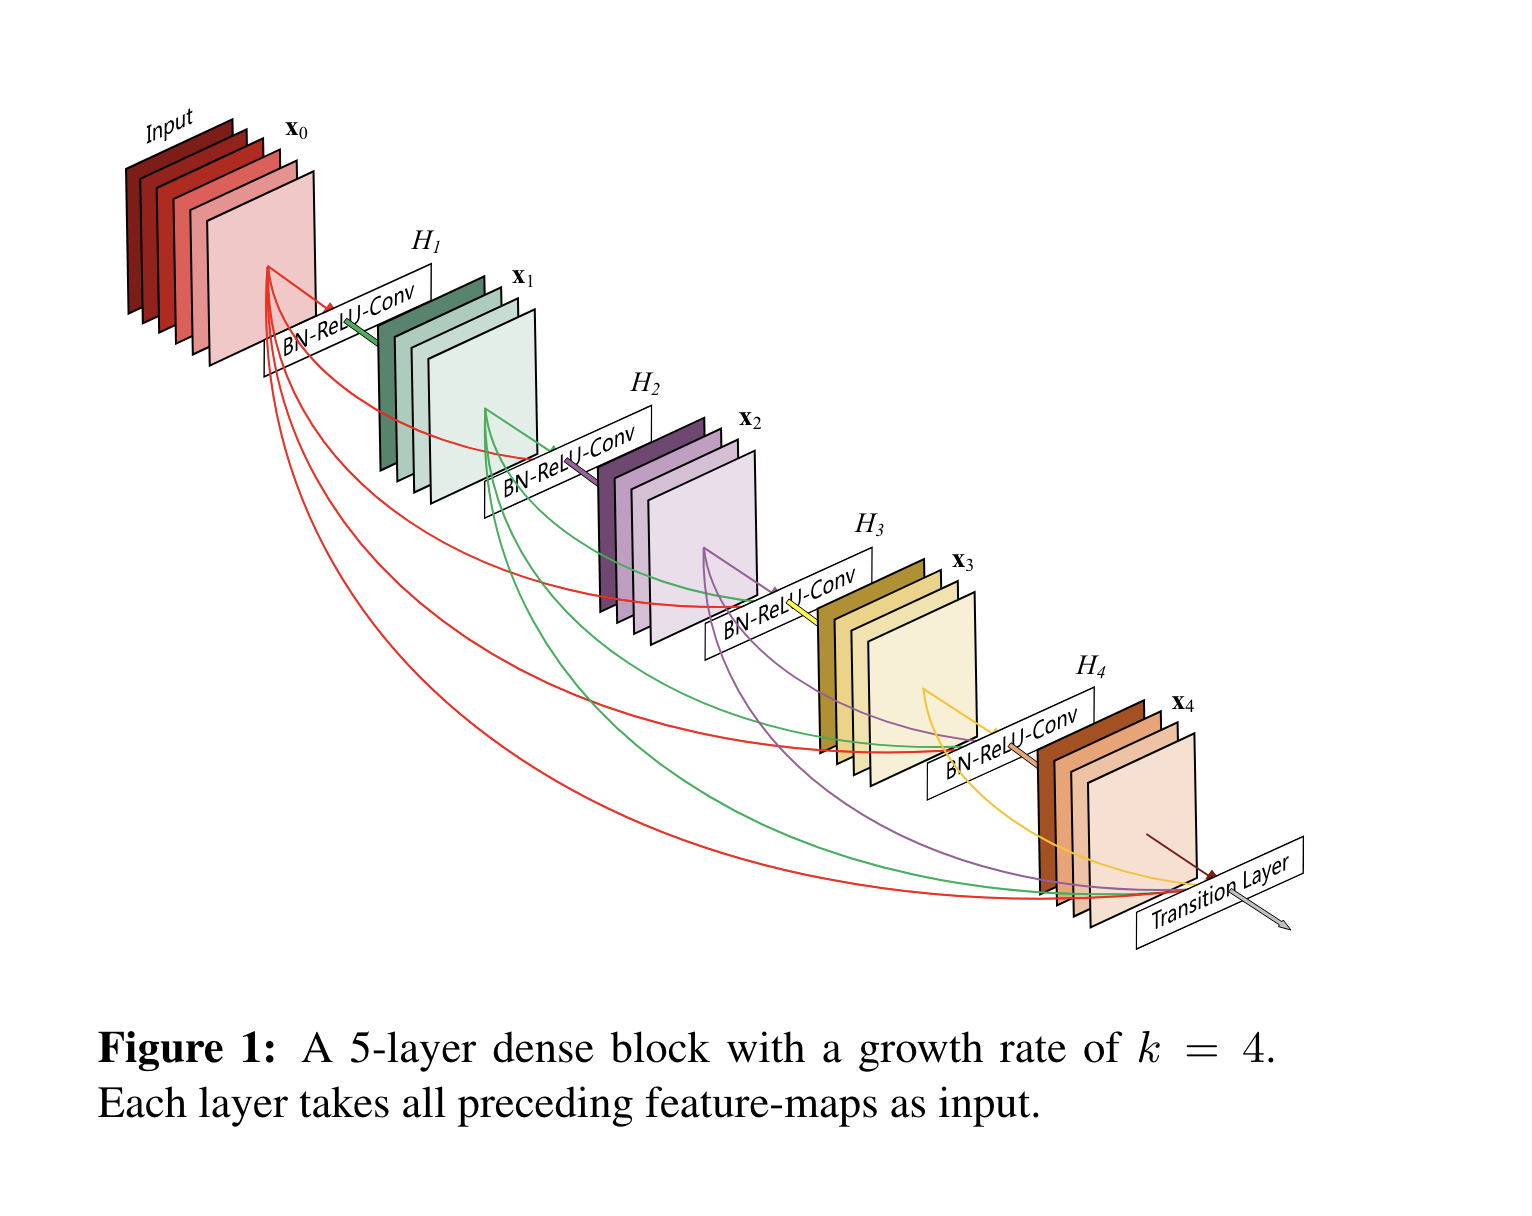

# Resources

https://medium.com/@karuneshu21/how-to-resnet-in-pytorch-9acb01f36cf5

https://medium.com/@karuneshu21/implement-densenet-in-pytorch-46374ef91900

Ref: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

https://medium.com/@freshtechyy/a-detailed-introduction-to-resnet-and-its-implementation-in-pytorch-744b13c8074a

https://pub.aimind.so/densenet-the-secret-to-parameter-efficiency-in-deep-learning-f08ac30b6542

# PyTorch ImageClassification Pipeline for CIFAR-10



### Imports and GPU Check

In [8]:
import torch
import torchvision
import torchvision.transforms as transforms
import os

!nvidia-smi

Mon Apr 14 13:13:43 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Preprocessing

First we need to prepare and load the dataset in a way that the model can understand. This section of the code does exactly that.

1. Define Transformations:

  Images in CIFAR-10 are raw pixel values. We apply a transformation pipeline to each image:
  Convert the image to a tensor (ToTensor).
  Normalize the pixel values so they’re centered around 0, making training more stable.

2. Load the CIFAR-10 Dataset

  The CIFAR-10 dataset contains small (32x32) color images across 10 different classes like cats, cars, planes, etc.
  We download the training and test sets and apply the transformation to each image.

      https://www.cs.toronto.edu/~kriz/cifar.html

3. Create Data Loaders

    Data loaders handle:

    Batching (grouping images to process together, batch_size=6),
    
    Shuffling (so the model doesn't learn a fixed order),

    Efficient data loading using background processes (num_workers=2).


4. Define Class Labels

    We store the 10 class names in a list so we can map the model’s numeric predictions (0–9) to human-readable labels like "cat" or "truck".




In [9]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


batch_size = 6

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)


testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

### PyTorch Tensor Format

In PyTorch, image tensors follow the format:

```[channels, height, width]```

So, a single color image (e.g., RGB) of size `256×256` would be represented as:
```[3, 256, 256]```

However, during training, images are processed in batches, and an extra dimension is added in the front to represent the batch size. So inside the forward method of your model, the input tensor shape will be:

```[batch_size, channels, height, width]```

For example, if your batch size is 6, the shape of the input will be:
`[6, 3, 32, 32]` for CIFAR-10 images.

In [10]:
for sample in trainloader:
  images, labels = sample

  break

images.size()

torch.Size([6, 3, 32, 32])

In [11]:
labels.size()

torch.Size([6])

### Visualizing Training Data


Looking at sample images from the training dataset to help us understand what the model will learn from.

1. Unnormalize and Display an Image Grid

    - Images were normalized during preprocessing (centered around 0). Here, we "unnormalize" them so they look like real images again.
    - The imshow() function reshapes and displays a grid of images using Matplotlib.

2. Sample a Random Batch

    We grab a random batch from the training loader using iter() and next(). This gives us both the images and their labels.

3. Visualize and Annotate

    - A grid of images is displayed.
    - Below the images, we print out their corresponding class labels like cat, ship, frog, etc.

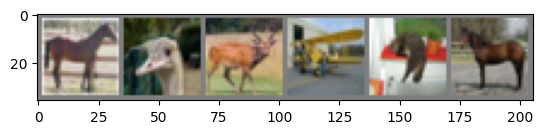

horse bird  deer  plane cat   horse


In [12]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### Defining the Neural Network

***Model Architecture***


- The class Net represents a Convolutional Neural Network (CNN).

- It inherits from nn.Module, which is the base class for all PyTorch models.
- Layers Used :
    - Convolutional Layers (conv1, conv2): These detect patterns like edges, textures, and shapes from the images.
    - Pooling Layer (pool): This reduces the spatial size of the features, helping the network generalize and reducing computation.
    - Fully Connected Layers (fc1, fc2, fc3): These perform high-level reasoning and make the final classification decision.

- Forward Pass

    - The forward() method defines how the data flows through the layers during prediction.
    - Activation functions like ReLU add non-linearity.
    - The tensor is flattened before entering the fully connected layers so it can be processed like a vector.

- This is inspired by [LeNet](https://colab.research.google.com/drive/1kvuqWor4TzpwWAlmrGWkYH_mFQopfH8_#scrollTo=t7jvXZzzV6SH&line=20&uniqifier=1).

In [13]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

### Setting Up Loss and Optimizer

- Loss Function (criterion)

    We use Cross-Entropy Loss, which is well-suited for multi-class classification problems.

- Optimizer (optimizer)
    The optimizer updates the model’s weights based on the computed loss.
    Here, we use Stochastic Gradient Descent (SGD) with:

    - Learning rate: Controls how big each update step is.
    - Momentum: Helps the optimizer move faster in the right direction and avoid getting stuck.

In [14]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Training the Neural Network

For each mini-batch:
  - Inputs and labels are loaded.
  - The model's gradients are reset (optimizer.zero_grad()).
  - A forward pass computes the model's predictions.
  - The loss is calculated (how wrong the model is).
  - A backward pass computes how to adjust weights (via gradients).
  - The optimizer updates the model’s parameters to reduce the loss.


For demonstration purposes, we run only 2 epochs. In practice, training should continue until the model converges — i.e., when the loss stabilizes and accuracy no longer improves significantly.

In [ ]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.157
[1,  4000] loss: 1.758
[1,  6000] loss: 1.567
[1,  8000] loss: 1.493
[2,  2000] loss: 1.414
[2,  4000] loss: 1.390
[2,  6000] loss: 1.350
[2,  8000] loss: 1.304
Finished Training


### Save trained model and Testing

In [16]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

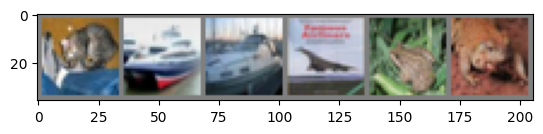

GroundTruth:  cat   ship  ship  plane


In [17]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [18]:
net = Net()
net.load_state_dict(torch.load(PATH))

outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  plane plane plane plane


In [19]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 10 %


In [20]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 99.8 %
Accuracy for class: car   is 0.0 %
Accuracy for class: bird  is 0.0 %
Accuracy for class: cat   is 0.0 %
Accuracy for class: deer  is 0.0 %
Accuracy for class: dog   is 0.0 %
Accuracy for class: frog  is 0.8 %
Accuracy for class: horse is 0.0 %
Accuracy for class: ship  is 0.0 %
Accuracy for class: truck is 0.0 %


## Training on GPU

In [21]:
!nvidia-smi

Mon Apr 14 14:09:58 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

***For GPU Training always make sure that the data tensors and model weights are on GPU***

*To find out the device of a tensor x, we can use x.get_device().*



In [24]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [25]:
net.to(device)
inputs, labels = data[0].to(device), data[1].to(device)

In [26]:
inputs.get_device()

0

In [27]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.304
[1,  4000] loss: 2.303
[1,  6000] loss: 2.304
[1,  8000] loss: 2.305
[2,  2000] loss: 2.304
[2,  4000] loss: 2.304
[2,  6000] loss: 2.304
[2,  8000] loss: 2.304
Finished Training
